In this context each book is be considered as an "arm" of the bandit, and the objective is to select books to show to users to maximize the cumulative reward (user engagement).

Given a system that shows recommended books to a user. The recommendations are taken from the recommendation engine and limited to 10 items. We'll show first top items to the user with a multi-armed bandit approach (ingesting random items from a rest of the list). If user has already interacted (clicked on a book) it will be shown first. And simulate user behavior. Each loop iteration imposes a page visit.

In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('..')
from src.recommenders.dnn_recommender import DNNRecommender
from src.utils.data_preprocessing import preprocess2

books = pd.read_csv('../data/Books.csv', delimiter=';', dtype={'ISBN': str, 'Title': str, 'Author': str, 'Year': np.int16, 'Publisher': str})
users = pd.read_csv('../data/Users.csv', delimiter=';', low_memory=False)
ratings = pd.read_csv('../data/Ratings.csv', delimiter=';', dtype={'User-ID': np.int32, 'ISBN': str, 'Rating': np.int8})

books, users, ratings = preprocess2(items=books, users=users, ratings=ratings)

In [2]:
data = pd.merge(ratings, books, on='ISBN')
data = pd.merge(data, users, on='User-ID')

# Filter out users and books with a small number of interactions
min_user_ratings = 5
min_book_ratings = 5

user_counts = data['User-ID'].value_counts()
book_counts = data['ISBN'].value_counts()

data = data[data['User-ID'].isin(user_counts[user_counts >= min_user_ratings].index)]
data = data[data['ISBN'].isin(book_counts[book_counts >= min_book_ratings].index)]

In [12]:
import random

def get_user_feedback():
    # User feedback simulation: 0 for no click, 1 for click
    return random.choice([0, 1]) 

# Get random user
user = data['User-ID'].sample(n=1)

# Get random recommendations (assume they are sorted by predicted rating)
n_recommendations = 100
n_shown = 10
recommendations = data['ISBN'].sample(n=n_recommendations)

# Init reward matrix
epsilon = 0.1

num_interactions = 1000


Epsilon-greedy approach
Values with rewards (clicks) are sorted on top of a pre-sorted by ratings array of books

In [74]:
rec_df = pd.DataFrame(recommendations, columns=['ISBN'])
rec_df.reset_index(drop=True, inplace=True)
rec_df['Count'] = 0
rec_df['Reward'] = 0

total_rewards = []

for j in range(num_interactions):
    rec_df['Reward/Count'] = rec_df.apply(lambda x: x['Reward'] / x['Count'] if x['Count'] != 0 else float('nan'), axis=1)
    rec_df = rec_df.sort_values(by='Reward/Count', ascending=False)

    # Get top 10 recommendations
    for i in range(n_shown):
        # Epsilon-greedy infusion
        if random.random() < epsilon:
            selected_i = random.randint(0, n_recommendations-1)
        else:
            selected_i = i

        reward = get_user_feedback()

        # Update the book reward tracker
        rec_df.loc[selected_i, 'Count'] += 1
        rec_df.loc[selected_i, 'Reward'] += reward
    
    total_rewards.append(rec_df['Reward'].sum())

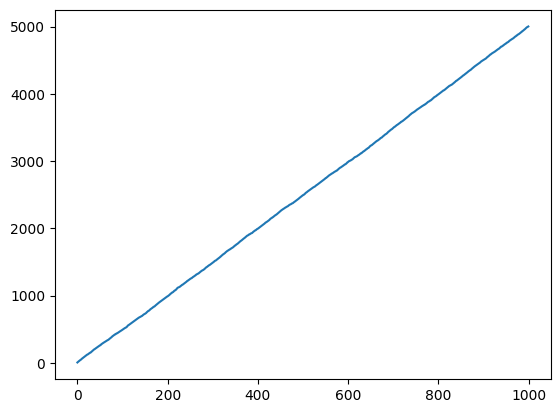

In [75]:
import matplotlib.pyplot as plt
plt.plot(total_rewards)

Thompson Sampling
Select a book with a highest sampled value from the Beta distribution, balancing exploration and exploitation probabilistically

In [70]:

rec_df = pd.DataFrame(recommendations, columns=['ISBN'])
rec_df.reset_index(drop=True, inplace=True)
rec_df['Success'] = 0
rec_df['Failure'] = 0
total_rewards = []

def thompson_sampling_select(recommended_books):
    sampled_values = [0]
    
    for book_idx in range(recommended_books.shape[0]):
        alpha = recommended_books.loc[book_idx, 'Success'] + 1
        beta = recommended_books.loc[book_idx, 'Failure'] + 1
        sampled_values.append(np.random.beta(alpha, beta))
    
    return np.argmax(sampled_values)-1


for j in range(num_interactions):
    rec_df['Reward/Count'] = rec_df.apply(lambda x: x['Success'] / (x['Success'] + x['Failure']) if (x['Success'] + x['Failure']) != 0 else float('nan'), axis=1)
    rec_df = rec_df.sort_values(by='Reward/Count', ascending=False)

    # Get top 10 recommendations
    for i in range(n_shown):
        # Thompson sampling infusion
        selected_i = thompson_sampling_select(rec_df)
        
        reward = get_user_feedback()

        # Update the book reward tracker
        if reward == 1:
            rec_df.loc[selected_i, 'Success'] += 1
        else:
            rec_df.loc[selected_i, 'Failure'] += 1
    
    total_rewards.append(rec_df['Success'].sum())

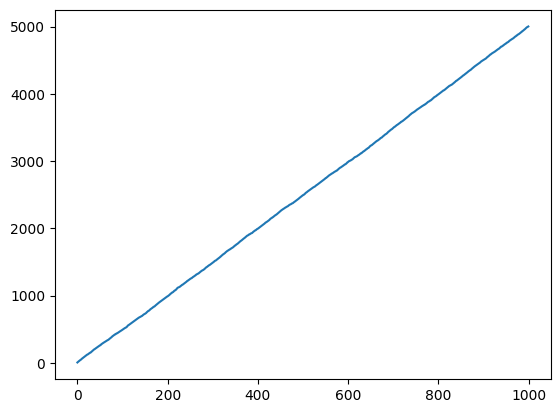

In [76]:
import matplotlib.pyplot as plt
plt.plot(total_rewards)